In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [57]:
data = pd.read_excel("summary_per_color_group.xlsx")
data

,Unnamed: 0,T258_dH+_red_mean,T258_dH+_red_std,T258_dH+_red_min,T258_dH+_red_25%,T258_dH+_red_50%,T258_dH+_red_75%,T258_dH+_red_max,T258_dH-_red_mean,T258_dH-_red_std,...,T278_SMR_diff_25%,T278_SMR_diff_50%,T278_SMR_diff_75%,T278_SMR_diff_max,T278_SMR_corr,T278_SMR_tau,id_test_attempt,id_sample,age,sex
0,61005,2.75,1.500000,1,1.75,3.0,4.00,4,1.00,0.816497,...,-0.111650,-0.003722,0.110599,0.298893,-0.348606,-0.231483,0,0,20.010959,1
1,47000,2.25,0.957427,1,1.75,2.5,3.00,3,0.75,0.500000,...,-0.051903,0.048618,0.063985,0.219723,0.102884,0.066421,0,1,20.013699,0
2,47466,1.75,0.957427,1,1.00,1.5,2.25,3,0.50,0.577350,...,-0.064603,-0.051664,0.073810,0.274372,-0.202019,-0.016667,0,2,20.112329,0
3,59980,2.00,0.816497,1,1.75,2.0,2.25,3,0.75,0.500000,...,-0.055315,-0.027076,0.070588,0.181467,0.019172,-0.049460,0,3,20.158904,0
4,47927,2.00,0.816497,1,1.75,2.0,2.25,3,0.25,0.500000,...,-0.129545,0.003198,0.072435,0.324830,-0.149060,-0.191063,1,4,20.158904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,54377,6.75,2.629956,3,6.00,7.5,8.25,9,10.00,0.000000,...,-0.168182,-0.004284,0.123874,0.438725,0.357924,0.218462,0,2811,82.610959,1
2999,54127,7.25,3.304038,3,6.00,7.5,8.75,11,5.50,2.380476,...,-0.075099,-0.000922,0.052347,0.393750,-0.397136,-0.306667,0,2812,83.375342,0
3000,54142,10.25,6.184658,3,7.50,10.0,12.75,18,7.25,1.892969,...,-0.103839,0.003205,0.131783,0.408466,-0.188465,-0.295840,0,2813,83.471233,0
3001,51135,13.00,4.966555,7,10.75,13.0,15.25,19,3.25,2.753785,...,-0.103728,-0.051200,0.083958,0.212740,-0.194597,-0.159420,0,2814,83.567123,1


Разделение данных на 3 выборки

In [59]:
x = data.drop(columns="age")
x = x.drop(columns=['Unnamed: 0', 'id_sample', 'id_test_attempt'])
y = data["age"]
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=10) 
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=10) # разбиение 20 20 60
c = x.columns.tolist()
with open('columns_list.txt', 'w') as f:
    for column in c:
        f.write(column + '\n')

Стандартизация данных ( приведение признаков к одинаковому масштабу, улучшает работу многих алгоритмов машинного обучения)

In [62]:
scaler = StandardScaler()
scaler.fit(x_train)  #обучение на тренировочных данных то етсь расчет среднего и дисперсии
x_train = scaler.transform(x_train)  #преобразование (стандартизация), или можно scaler.fit_transform
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [63]:
def built_real_pred_age_scatter(real_train, real_test, pred_test, pred_train, mae_test, mae_train):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax1, ax2 = axes
    
    sns.scatterplot(x=real_test, y=pred_test, alpha=0.5, ax=ax1, color='green')
    ax1.plot([10,85], [10,85], color="grey", linestyle='--')
    ax1.set_title('Тестовые данные', loc='left', fontsize=15)
    corr_test, _ = pearsonr(real_test, pred_test)
    ax1.text(0.05, 0.86, f'corr: {corr_test:.2f}', transform=ax1.transAxes, fontsize=12)
    ax1.text(0.05, 0.95, f'MAE: {mae_test:.2f}', transform=ax1.transAxes, fontsize=12)
    lowess_res = sm.nonparametric.lowess(exog=real_test, endog=pred_test, frac=0.3)     
    ax1.plot(lowess_res[:, 0], lowess_res[:, 1], linewidth=2, color='black', label='Линия тренда (LOWESS)')
    sns.regplot(x=real_test, y=pred_test, ax=ax1, scatter=False, color='red', label='Линия регрессии')
    ax1.set_xlabel('Хронологический возраст', fontsize=15, fontweight='light')
    ax1.set_ylabel('Когнитивный возраст', fontsize=15, fontweight='light')
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend(fontsize=15)

    
    sns.scatterplot(x=real_train, y=pred_train, alpha=0.5, ax=ax2)
    ax2.plot([10,85], [10,85], color="grey", linestyle='--')
    ax2.set_title('Обучающие данные', loc='left', fontsize=15)
    corr_train, _ = pearsonr(real_train, pred_train)
    ax2.text(0.05, 0.86, f'corr: {corr_train:.2f}', transform=ax2.transAxes, fontsize=12)
    ax2.text(0.05, 0.95, f'MAE: {mae_train:.2f}', transform=ax2.transAxes, fontsize=12) #4 параметр это система координат относительно осей
    lowess_res = sm.nonparametric.lowess(exog=real_train, endog=pred_train, frac=0.3)     
    ax2.plot(lowess_res[:, 0], lowess_res[:, 1], linewidth=2, color='black', label='Линия тренда (LOWESS)')
    sns.regplot(x=real_train, y=pred_train, ax=ax2, scatter=False, color='red', label='Линия регрессии')
    ax2.set_xlabel('Хронологический возраст', fontsize=15, fontweight='light')
    ax2.set_ylabel('Когнитивный возраст', fontsize=15, fontweight='light')
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.legend(fontsize=15)

In [64]:
def calc_mae(y_test, y_pred_test, y_val, y_pred_val, y_train, y_pred_train):
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"MAE на тренировочной выборке {mae_train}\nMAE на валидационной выборке {mae_val}\nMAE на тестовой выборке {mae_test}\n")
    return mae_test, mae_train, mae_val

1 год между mae train и test это хорошо

Разбиение для кросс валидации

In [67]:
x_train_val = np.vstack([x_train, x_val])
y_train_val = np.concatenate([y_train, y_val])
split_index = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=split_index)

## KNN
Подход, основанный на предположении, что похожие объекты имеют схожие значения целевой переменной. В отличие от сложных моделей, KNN не строит явную математическую зависимость, а просто запоминает обучающие данные и для каждого нового объекта ищет k наиболее близких примеров, чтобы предсказать их среднее значение


**Гиперпараметры:**
- `n_neighbors` (k) — количество соседей
- `weights` — вес соседей
- `p` — метрика расстояния

scoring='neg_mean_absolute_error' потому что GridSearchCV по умолчанию максимизирует метрику, а MAE нужно минимизировать. Поэтому она берёт отрицательное значение, чтобы "максимум" соответствовал "минимальной ошибке". cv это количество фолдов для кросс-валидации

In [71]:
knn = KNeighborsRegressor()  
#сетка параметров 
param_grid = { 
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid = GridSearchCV(knn, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(x_train, y_train)
best_knn_1 = grid.best_estimator_   #лучшая модель
'''
y_pred_knn_val_grid = best_knn.predict(x_val)
mae_knn_val_grid = mean_absolute_error(y_pred_knn_val_grid, y_val)
print(f"MAE на валидационной выборке с gridsearch {mae_knn_val_grid}")
print(f'Лучшие параметры: {grid.best_params_}\n')
'''


'\ny_pred_knn_val_grid = best_knn.predict(x_val)\nmae_knn_val_grid = mean_absolute_error(y_pred_knn_val_grid, y_val)\nprint(f"MAE на валидационной выборке с gridsearch {mae_knn_val_grid}")\nprint(f\'Лучшие параметры: {grid.best_params_}\n\')\n'

In [72]:
y_pred_knn_test = best_knn_1.predict(x_test)
y_pred_knn_train = best_knn_1.predict(x_train)
y_pred_knn_val = best_knn_1.predict(x_val)
mae_knn_test, mae_knn_train, mae_knn_val  = calc_mae(y_test, y_pred_knn_test, y_val, y_pred_knn_val, y_train, y_pred_knn_train)
print(f'Лучшие параметры: {grid.best_params_}\n')

MAE на тренировочной выборке 0.0030148649025528943
MAE на валидационной выборке 7.224430730764943
MAE на тестовой выборке 7.013896347047926

Лучшие параметры: {'n_neighbors': 18, 'p': 1, 'weights': 'distance'}



In [73]:
grid = GridSearchCV(
    knn, 
    param_grid, 
    cv=ps,
    scoring='neg_mean_absolute_error'
)
grid.fit(x_train_val, y_train_val)
best_knn_2 = grid.best_estimator_   #лучшая модель
y_pred_knn_test = best_knn_2.predict(x_test)
y_pred_knn_train = best_knn_2.predict(x_train)
y_pred_knn_val = best_knn_2.predict(x_val)
mae_knn_test, mae_knn_train, mae_knn_val  = calc_mae(y_test, y_pred_knn_test, y_val, y_pred_knn_val, y_train, y_pred_knn_train)
print(f'Лучшие параметры: {grid.best_params_}\n')

MAE на тренировочной выборке 0.004261660822627745
MAE на валидационной выборке 0.0048515791792977415
MAE на тестовой выборке 6.986873132660071

Лучшие параметры: {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}



Сохранение ошибок для каждых параметров сетки

In [75]:
errors_knn_df = pd.DataFrame(grid.cv_results_)
errors_knn_df = pd.DataFrame(grid.cv_results_)[[
    'param_n_neighbors',
    'param_weights',
    'param_p',
    'mean_test_score',
]]
errors_knn_df['mean_test_mae'] = -errors_knn_df['mean_test_score']
errors_knn_df

,param_n_neighbors,param_weights,param_p,mean_test_score,mean_test_mae
0,1,uniform,1,-9.259096,9.259096
1,1,distance,1,-9.259096,9.259096
2,1,uniform,2,-10.123321,10.123321
3,1,distance,2,-10.123321,10.123321
4,2,uniform,1,-8.493314,8.493314
...,...,...,...,...,...
75,19,distance,2,-7.437334,7.437334
76,20,uniform,1,-7.710875,7.710875
77,20,distance,1,-7.278186,7.278186
78,20,uniform,2,-7.896566,7.896566


In [109]:
knn = KNeighborsRegressor()  
knn.fit(x_train, y_train)
y_pred_knn_test = knn.predict(x_test)
y_pred_knn_train = knn.predict(x_train)
y_pred_knn_val = knn.predict(x_val)
mae_knn_test, mae_knn_train, mae_knn_val  = calc_mae(y_test, y_pred_knn_test, y_val, y_pred_knn_val, y_train, y_pred_knn_train)

MAE на тренировочной выборке 6.803800384869898
MAE на валидационной выборке 8.356380279442938
MAE на тестовой выборке 8.174336471178174



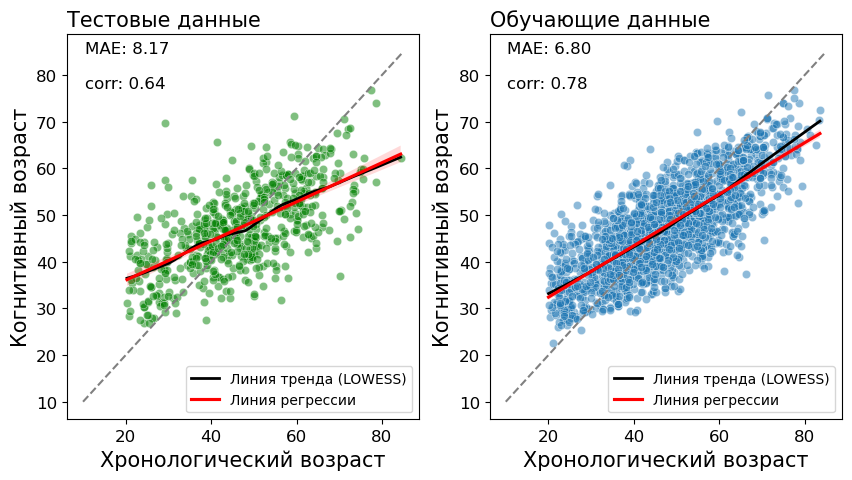

In [113]:
built_real_pred_age_scatter(y_train, y_test, y_pred_knn_test, y_pred_knn_train, mae_knn_test, mae_knn_train) 

## SVR
SVR алгоритм машинного обучения, основанный на методах опорных векторов. Он строит математическую модель, пытаясь найти гиперплоскость, которая минимизирует ошибку, но при этом учитывает только те точки, которые выходят за пределы заданной границы (эпсилон-трубки). Это делает SVR устойчивым к выбросам и хорошо работающим в высокоразмерных пространствах

Стал работать только после стандартизации данных

**Гиперпараметры:**
- С помощью ядра (kernel) данные могут быть «отображены» в высокоразмерное пространство, где линейная функция в этом 
пространстве соответствует нелинейной в исходном.
1)kernel='linear' — просто линейная регрессия с ε-tube и регуляризацией.
2)kernel='rbf' — гауссовское ядро, позволяет гибко подстраиваться под данные.
- `c` - штраф за нарушение окресности трубки. Большой C → модель старается «проглотить» меньше ошибок (меньше подгон). Малый C → более гладкая,
   слабее подгоняет шум.
- `epsilon` — половина ширины невознаграждаемой трубки. Чем больше ε, тем больший допуск к ошибкам → более гладкая модель.
- `gamma` — для ядер 'rbf', 'poly', 'sigmoid'. Управляет «радиусом» влияния одной точки: малое gamma → дальнее влияние, модель более гладкая; большое gamma → узкое влияние, может переобучаться.

In [93]:
svr = SVR(kernel='rbf') #гауссовское ядро
#сетка параметров 
param_grid = { 
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}
grid = GridSearchCV(svr, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(x_train, y_train)
best_svr = grid.best_estimator_   #лучшая модель
y_pred_svr_val_grid = best_svr.predict(x_val)
mae_svr_val_grid = mean_absolute_error(y_pred_svr_val_grid, y_val)
print(f"MAE на валидационной выборке с gridsearch {mae_svr_val_grid}")
print(f'Лучшие параметры: {grid.best_params_}\n')

y_pred_svr_test = best_svr.predict(x_test)
y_pred_svr_train = best_svr.predict(x_train)
y_pred_svr_val = best_svr.predict(x_val)
mae_svr_test, mae_svr_train, mae_svr_val  = calc_mae(y_test, y_pred_svr_test, y_val, y_pred_svr_val, y_train, y_pred_svr_train)

MAE на валидационной выборке с gridsearch 7.27657070432404
Лучшие параметры: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale'}

MAE на тренировочной выборке 4.2949822811782346
MAE на валидационной выборке 7.27657070432404
MAE на тестовой выборке 7.225731271813



In [94]:
grid = GridSearchCV(
    svr, 
    param_grid, 
    cv=ps,
    scoring='neg_mean_absolute_error'
)
grid.fit(x_train_val, y_train_val)
best_svr_2 = grid.best_estimator_   #лучшая модель
y_pred_svr_test = best_svr_2.predict(x_test)
y_pred_svr_train = best_svr_2.predict(x_train)
y_pred_svr_val = best_svr_2.predict(x_val)
mae_svr_test, mae_svr_train, mae_svr_val  = calc_mae(y_test, y_pred_svr_test, y_val, y_pred_svr_val, y_train, y_pred_svr_train)
print(f'Лучшие параметры: {grid.best_params_}\n')

MAE на тренировочной выборке 5.051489356070313
MAE на валидационной выборке 5.12232753549941
MAE на тестовой выборке 7.0084935452737325

Лучшие параметры: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale'}



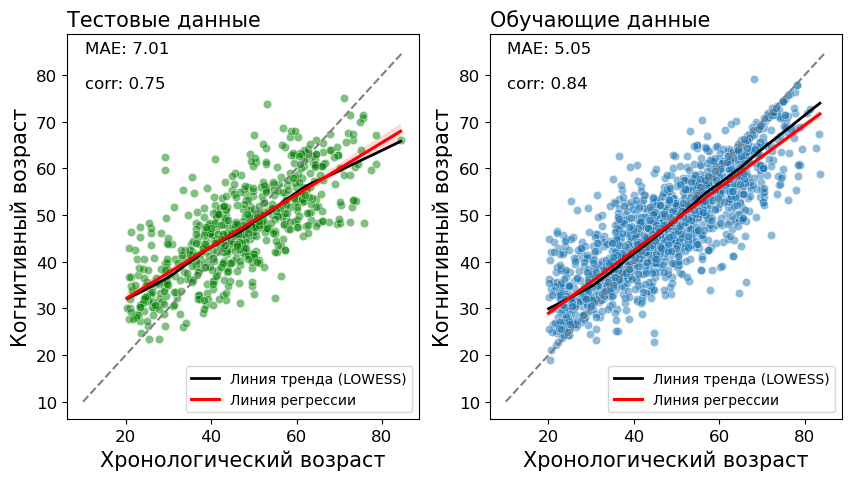

In [115]:
built_real_pred_age_scatter(y_train, y_test, y_pred_svr_test, y_pred_svr_train, mae_svr_test, mae_svr_train) 

## Дерево решений
Работают по принципу последовательного разбиения данных на подгруппы, чтобы минимизировать дисперсию целевой переменной в каждом листе. Они интуитивно понятны, так как их можно визуализировать, и они автоматически учитывают нелинейные зависимости и взаимодействия признаков. Легко переобучается, когда в каждом листе 1 объект. Дерево решений ищет лучший признак для разделения данных в каждом узле (признаки — это столбцы датасета). В дереве решений предсказание — это среднее значение целевой переменной в листе.


**Гиперпараметры:**
- `max_depth` - глубмна дерева. Обычно 3-10
- `min_samples_leaf` —минимальное число образцов в листе. Контролирует, сколько образцов должно остаться в конечном листе после разделения
- `min_samples_split` — минимальное число образцов для разделения узла. Определяет, сколько образцов должно быть в узле, чтобы его можно было разделить на поддеревья
- `max_features` - количество признаков для поиска разделения. Определяет, сколько признаков рассматривать при поиске лучшего разделения в узле
- `criterion` - критерий качества разделения: 'squared_error' (MSE), 'friedman_mse' - улучшенная mse, 'absolute_error' (MAE).
- `random state`

In [29]:
tree = DecisionTreeRegressor(random_state=10)
#сетка параметров 
param_grid = {
    'max_depth': [3, 5, 7, 10, 12],          
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4, 8],     
    'max_features': ['sqrt', None],  # none это все
    'random_state': [10]             # Для воспроизводимости
}
grid = GridSearchCV(tree, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(x_train, y_train)
best_tree = grid.best_estimator_   #лучшая модель
print(f'Лучшие параметры: {grid.best_params_}\n')

best_tree.fit(x_train, y_train)
y_pred_tree_train = best_tree.predict(x_train)
y_pred_tree_test = best_tree.predict(x_test)
y_pred_tree_val = best_tree.predict(x_val)
mae_tree_test, mae_tree_train, mae_tree_val  = calc_mae(y_test, y_pred_tree_test, y_val, y_pred_tree_val, y_train, y_pred_tree_train)

Лучшие параметры: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 10}

MAE на тренировочной выборке 6.543149993421992
MAE на валидационной выборке 8.11618471789061
MAE на тестовой выборке 8.160572996877425



In [35]:
grid = GridSearchCV(
    tree, 
    param_grid, 
    cv=ps,
    scoring='neg_mean_absolute_error'
)
grid.fit(x_train_val, y_train_val)
best_tree_2 = grid.best_estimator_   #лучшая модель
y_pred_tree_test = best_tree_2.predict(x_test)
y_pred_tree_train = best_tree_2.predict(x_train)
y_pred_tree_val = best_tree_2.predict(x_val)
print(f'Лучшие параметры: {grid.best_params_}\n')
mae_tree_test, mae_tree_train, mae_tree_val  = calc_mae(y_test, y_pred_tree_test, y_val, y_pred_tree_val, y_train, y_pred_tree_train)

Лучшие параметры: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 10}

MAE на тренировочной выборке 7.388278235599524
MAE на валидационной выборке 7.390470280479004
MAE на тестовой выборке 8.159222993453794



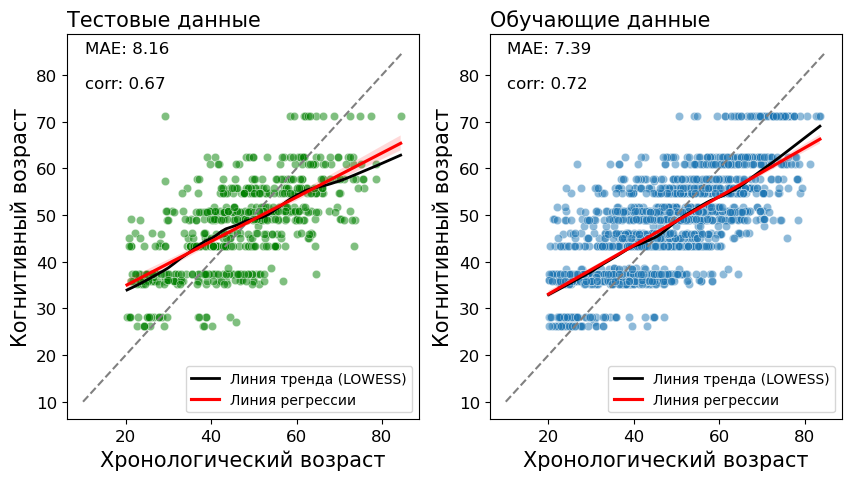

In [37]:
built_real_pred_age_scatter(y_train, y_test, y_pred_tree_test, y_pred_tree_train, mae_tree_test, mae_tree_train) 

## Градиентный бустиннг
Это более продвинутый подход, который строит ансамбль из множества слабых моделей (обычно деревьев), последовательно улучшая предсказания за счёт минимизации ошибки через градиентный спуск. Он сочетает в себе преимущества деревьев — работу с нелинейными зависимостями и категориальными признаками — с высокой точностью и устойчивостью к переобучению благодаря регуляризации.
Каждый следующий алгоритм уменьшает ошибку предыдущего.

**Гиперпараметры:**
- `n_estimators` - количество деревьев в ансамбле
- `learning_rate` - шаг градиентного спуска. Меньшие значения требуют больше деревьев, но улучшают обобщение
- `colsample_bytree` -  lоля признаков для каждого дерева. Уменьшает корреляцию между деревьями
- `max_depth` - глубина дерева
- `min_child_weight` - минимальная сумма весов (количество наблюдений) в листе
- `subsample` - доля строк обучающей выборки, используемая при построении каждого дерева
- `gamma` - минимальный "loss reduction" для разделения узла

In [9]:
xgb = XGBRegressor(random_state = 10, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 300, 500],        
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [3, 5, 7],     
    'min_child_weight': [1, 3, 5],  
    'subsample': [0.6, 0.8, 1.0], 
    'gamma': [0, 0.1, 0.3],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


grid = GridSearchCV(
    xgb, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

import psutil, os
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / 1024**2

grid.fit(x_train, y_train)

end_mem = process.memory_info().rss / 1024**2
print(f"Использовано памяти: {end_mem - start_mem:.2f} MB\n")


best_xgb = grid.best_estimator_   #лучшая модель
print(f'Лучшие параметры: {grid.best_params_}\n')

best_xgb.fit(x_train, y_train)
y_pred_xgb_test = best_xgb.predict(x_test)
y_pred_xgb_train = best_xgb.predict(x_train)
y_pred_xgb_val = best_xgb.predict(x_val)
mae_xgb_test, mae_xgb_train, mae_xgb_val  = calc_mae(y_test, y_pred_xgb_test, y_val, y_pred_xgb_val, y_train, y_pred_xgb_train)

Использовано памяти: 57.23 MB

Лучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}

MAE на тренировочной выборке 0.4092651942718667
MAE на валидационной выборке 6.411951216214976
MAE на тестовой выборке 6.110964846398107



In [35]:
xgb = XGBRegressor(random_state = 10, colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8)
xgb.fit(x_train, y_train)
y_pred_xgb_test = xgb.predict(x_test)
y_pred_xgb_train = xgb.predict(x_train)
y_pred_xgb_val = xgb.predict(x_val)
mae_xgb_test, mae_xgb_train, mae_xgb_val  = calc_mae(y_test, y_pred_xgb_test, y_val, y_pred_xgb_val, y_train, y_pred_xgb_train)

MAE на тренировочной выборке 4.6068336538793995
MAE на валидационной выборке 6.596814548808142
MAE на тестовой выборке 6.502530322860145



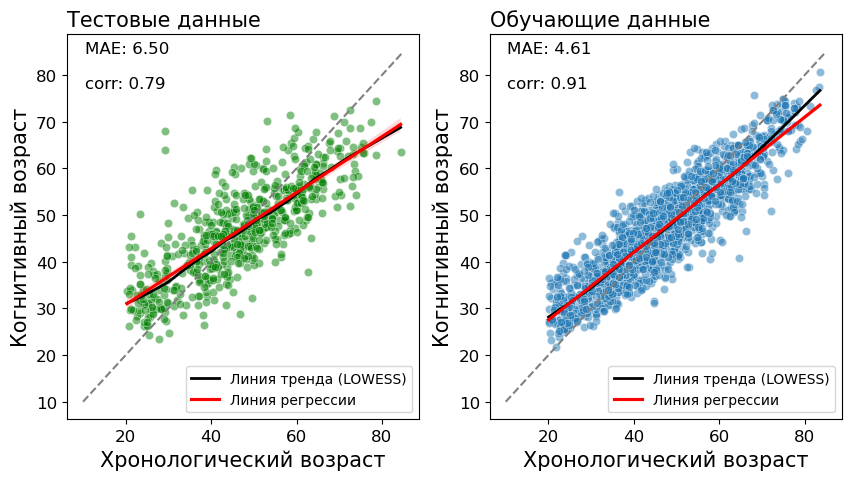

In [37]:
built_real_pred_age_scatter(y_train, y_test, y_pred_xgb_test, y_pred_xgb_train, mae_xgb_test, mae_xgb_train) 

<Figure size 1000x800 with 0 Axes>

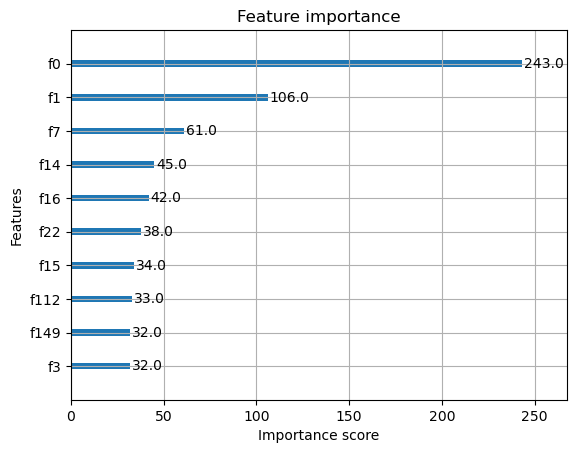

In [137]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plot_importance(xgb, max_num_features=10)
plt.show()